# Phishing email classification
## Smart Systems Group - ECE 569A
### Members:
*   Ahmadmahdi Abedini V01042492
*   Arman Dadrass V00039091
*   Thet Naung San V01023377
*   Zhuo Chen V00878798


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import regex as re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import nltk
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV


## Data Collection

In [2]:
# install kaggle and unzip the source file
!pip install kaggle
!kaggle datasets download -d subhajournal/phishingemails
!unzip /content/phishingemails.zip

Dataset URL: https://www.kaggle.com/datasets/subhajournal/phishingemails
License(s): GNU Lesser General Public License 3.0
 89% 16.0M/18.0M [00:01<00:00, 23.4MB/s]
100% 18.0M/18.0M [00:01<00:00, 14.6MB/s]
Archive:  /content/phishingemails.zip
  inflating: Phishing_Email.csv      


In [3]:
# load raw data from csv file
source_raw_data = pd.read_csv('/content/Phishing_Email.csv')

In [4]:
# display the raw dataset information
source_raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18650 entries, 0 to 18649
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  18650 non-null  int64 
 1   Email Text  18634 non-null  object
 2   Email Type  18650 non-null  object
dtypes: int64(1), object(2)
memory usage: 437.2+ KB


In [5]:
# display the number of samples for each class: Safe and Phishing
source_raw_data['Email Type'].value_counts()

,count
Email Type,
Safe Email,11322
Phishing Email,7328


In [6]:
# display first five samples
source_raw_data.head()

,Unnamed: 0,Email Text,Email Type
0,0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email
1,1,the other side of * galicismos * * galicismo *...,Safe Email
2,2,re : equistar deal tickets are you still avail...,Safe Email
3,3,\nHello I am your hot lil horny toy.\n I am...,Phishing Email
4,4,software at incredibly low prices ( 86 % lower...,Phishing Email


## Data Preprocessing and Visualization

In [7]:
# copy the dataset
df_raw=source_raw_data.copy()

In [8]:
# drop the column 'Unnamed: 0' as it does not provide any information for training
df_raw=df_raw.drop("Unnamed: 0",axis=1)

In [9]:
# check the missing value
print(df_raw[df_raw['Email Text'].isna()])

      Email Text      Email Type
31           NaN  Phishing Email
387          NaN  Phishing Email
1883         NaN  Phishing Email
2049         NaN  Phishing Email
2451         NaN  Phishing Email
2972         NaN  Phishing Email
3627         NaN  Phishing Email
3806         NaN  Phishing Email
5763         NaN  Phishing Email
6299         NaN  Phishing Email
6821         NaN  Phishing Email
8594         NaN  Phishing Email
9999         NaN  Phishing Email
11069        NaN  Phishing Email
11320        NaN  Phishing Email
13843        NaN  Phishing Email


### Imputation

In [10]:
# impute the placeholder 'Missing Content' for all NaN samples, as they represent Phishing Emails
df_raw.fillna(value='Missing Content', inplace=True)
df=df_raw.copy()
# convert the labels, 'positive' represents anomalous samples and 'negative' represents benign samples
label_mapping = {'Phishing Email': 1, 'Safe Email': -1}
df['Email Type Encoded'] = df['Email Type'].map(label_mapping)

### Text Data Cleaning

In [11]:
nltk.download('stopwords')
stopwords = set(stopwords.words('english'))
# create functions for tokenization, lowercasing, removing stop words, and word stemming

# split text into individual tokens
def tokenize(text):
    return re.findall(r'[\w-]*\p{L}[\w-]*', text)
# convert text to lower case
def lower_text(text):
    return text.lower()
# filter out common words, like 'and', 'the', 'I', etc
def remove_stop_words(tokens):
    return [token for token in tokens if token not in stopwords]
# reduce the word to their root form
def stem_words(tokens):
    stemmer = PorterStemmer()
    return [stemmer.stem(token) for token in tokens]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [12]:
# create transformers for each function
lower_case_transformer = FunctionTransformer(lower_text)
tokenizer_transformer = FunctionTransformer(tokenize)
removestop_transformer = FunctionTransformer(remove_stop_words)
stem_transformer = FunctionTransformer(stem_words)
# build a pipeline to process the input with the predefined transformers
pipeline = Pipeline([
    ('lower_text', lower_case_transformer),
    ('tokenizer', tokenizer_transformer),
    ('removestop',removestop_transformer),
    ('stem', stem_transformer)
])
pipeline

Pipeline(steps=[('lower_text',
                 FunctionTransformer(func=<function lower_text at 0x7a495c78f1c0>)),
                ('tokenizer',
                 FunctionTransformer(func=<function tokenize at 0x7a495d8f0e50>)),
                ('removestop',
                 FunctionTransformer(func=<function remove_stop_words at 0x7a495c78f250>)),
                ('stem',
                 FunctionTransformer(func=<function stem_words at 0x7a495c78f2e0>))])

In [13]:
# apply the pipeline to the 'Email Text' data
df['tokens'] = df['Email Text'].apply(pipeline.transform)
df.head()

,Email Text,Email Type,Email Type Encoded,tokens
0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email,-1,"[disc, uniformitarian, sex, lang, dick, hudson..."
1,the other side of * galicismos * * galicismo *...,Safe Email,-1,"[side, galicismo, galicismo, spanish, term, na..."
2,re : equistar deal tickets are you still avail...,Safe Email,-1,"[equistar, deal, ticket, still, avail, assist,..."
3,\nHello I am your hot lil horny toy.\n I am...,Phishing Email,1,"[hello, hot, lil, horni, toy, one, dream, open..."
4,software at incredibly low prices ( 86 % lower...,Phishing Email,1,"[softwar, incred, low, price, lower, draperi, ..."


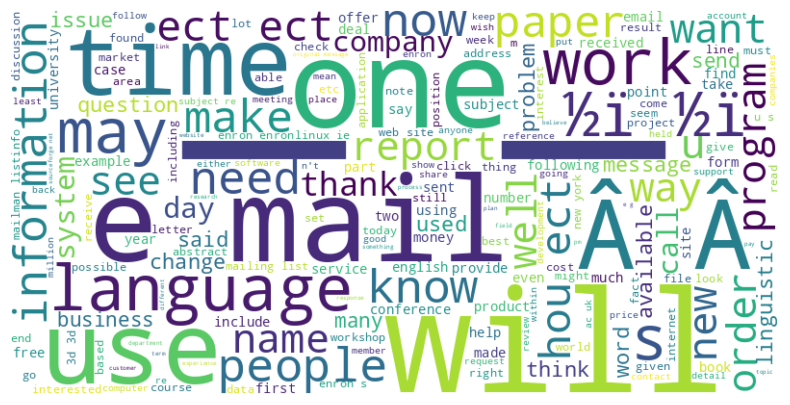

In [14]:
# visualize the original text
text = ' '.join(df['Email Text'])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

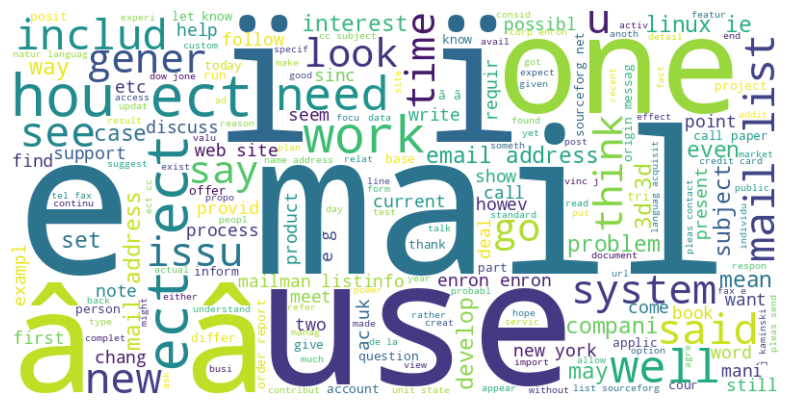

In [15]:
# visualize the processed tokens
all_tokens = [token for sublist in df['tokens'] for token in sublist]
text = ' '.join(all_tokens)

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [16]:
def join_tokens(tokens):
    return ' '.join(tokens)
df['joined_tokens'] = df['tokens'].apply(join_tokens)
# use the TF-IDF methodology to extract features from the raw textual data
tfidf = TfidfVectorizer(min_df=5, max_df=0.5, ngram_range=(1, 1))
# split X to be the feature set and y to be the labels
X = tfidf.fit_transform(df['joined_tokens'])
y = np.array(df['Email Type Encoded'])
print(X.shape)

(18650, 25469)


### Dimensionality Reduction using Truncated SVD

In [17]:
# apply Truncated SVD to reduce the dimensionality of the feature set to 50 features
svd_model = TruncatedSVD(n_components=50, algorithm='randomized', n_iter=5, random_state=None)
X_svd = svd_model.fit_transform(X)
print(X_svd.shape)

(18650, 50)


## Hyperparameter Tuning and Model Training

In [18]:
# prepare the datasets by allocating 80% for training and validation, and 20% for testing of the total data
X_train_val, X_test, y_train_val, y_test = train_test_split(X_svd, y, test_size=0.2, random_state=42)

In [23]:
# declare an instance of a Decision Tree classifier with Gini
dt_gini = DecisionTreeClassifier(random_state=42)
# declare an instance of a Decision Tree classifier with Entropy
dt_entropy = DecisionTreeClassifier(criterion='entropy', random_state=42)
param_grid = {
    'max_depth': [None, 10, 20, 40],  # maximum depth of the tree
    'min_samples_split': [2, 5, 10], # minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4] # minimum number of samples required to be at a leaf node
}

# tune the Decision Tree model with the defined grid, using a cross-validation strategy.
# the assessment is based on the positive F1 score
grid_search_gini = GridSearchCV(estimator=dt_gini, param_grid=param_grid, cv=3, scoring='f1', n_jobs=-1)
grid_search_entropy = GridSearchCV(estimator=dt_entropy, param_grid=param_grid, cv=3, scoring='f1', n_jobs=-1)
grid_search_gini.fit(X_train_val, y_train_val)
grid_search_entropy.fit(X_train_val, y_train_val)

GridSearchCV(cv=3,
             estimator=DecisionTreeClassifier(criterion='entropy',
                                              random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20, 40],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             scoring='f1')

# Model Performance Evaluation and Classification - GINI

In [27]:
# Evaluate the best model for Gini
best_model_gini = grid_search_gini.best_estimator_

# Make predictions on the test set
y_pred_gini = best_model_gini.predict(X_test)

# Import necessary metrics for evaluation
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns

# Compute the confusion matrix for Gini model
conf_matrix_gini = confusion_matrix(y_test, y_pred_gini)
print("Confusion Matrix for Gini:")
print(conf_matrix_gini)

# Extract TN, FP, FN, TP from the confusion matrix for Gini model
TN_gini, FP_gini, FN_gini, TP_gini = conf_matrix_gini.ravel()
print(f"True Negatives (TN) for Gini: {TN_gini}")
print(f"False Positives (FP) for Gini: {FP_gini}")
print(f"False Negatives (FN) for Gini: {FN_gini}")
print(f"True Positives (TP) for Gini: {TP_gini}")

# Compute and print the classification report for Gini model
class_report_gini = classification_report(y_test, y_pred_gini)
print("\nClassification Report for Gini:")
print(class_report_gini)

# Compute and print the accuracy score for Gini model
accuracy_gini = accuracy_score(y_test, y_pred_gini)
print("\nAccuracy Score for Gini:", accuracy_gini)


Confusion Matrix for Gini:
[[2114  159]
 [ 107 1350]]
True Negatives (TN) for Gini: 2114
False Positives (FP) for Gini: 159
False Negatives (FN) for Gini: 107
True Positives (TP) for Gini: 1350

Classification Report for Gini:
              precision    recall  f1-score   support

          -1       0.95      0.93      0.94      2273
           1       0.89      0.93      0.91      1457

    accuracy                           0.93      3730
   macro avg       0.92      0.93      0.93      3730
weighted avg       0.93      0.93      0.93      3730


Accuracy Score for Gini: 0.928686327077748


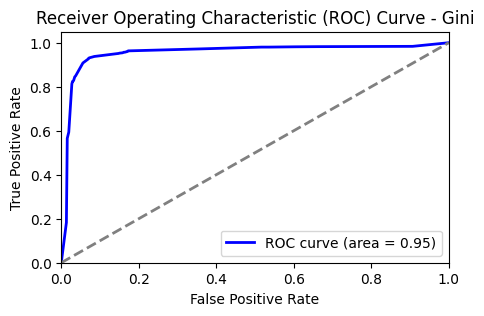

ROC AUC for Gini: 0.95


In [29]:
# Evaluate the model with ROC curve and AUC for Gini
y_pred_proba_gini = best_model_gini.predict_proba(X_test)[:, 1]  # Get the predicted probabilities for the positive class

# Calculate ROC curve
fpr_gini, tpr_gini, thresholds_gini = roc_curve(y_test, y_pred_proba_gini)
roc_auc_gini = roc_auc_score(y_test, y_pred_proba_gini)

# Plot ROC curve
plt.figure(figsize=(5, 3))
plt.plot(fpr_gini, tpr_gini, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_gini)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Gini')
plt.legend(loc="lower right")
plt.show()

# Print AUC
print(f"ROC AUC for Gini: {roc_auc_gini:.2f}")


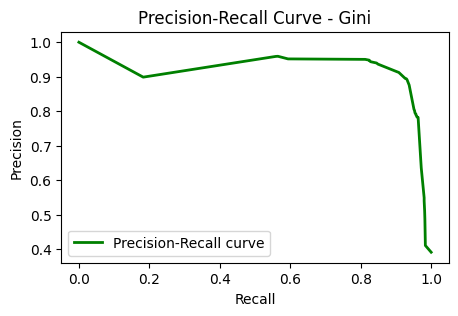

In [30]:
# Calculate Precision-Recall curve for Gini
precision_gini, recall_gini, pr_thresholds_gini = precision_recall_curve(y_test, y_pred_proba_gini)

# Plot Precision-Recall curve
plt.figure(figsize=(5, 3))
plt.plot(recall_gini, precision_gini, color='green', lw=2, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Gini')
plt.legend(loc="lower left")
plt.show()


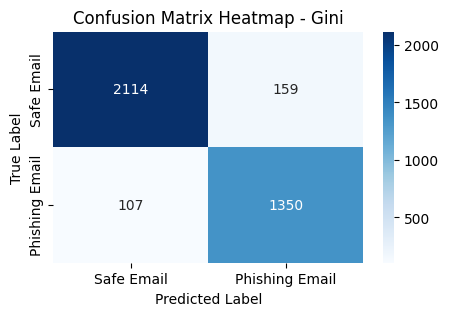

In [31]:
# Visualize the Confusion Matrix as a heatmap for Gini
plt.figure(figsize=(5, 3))
sns.heatmap(conf_matrix_gini, annot=True, fmt='d', cmap='Blues', xticklabels=['Safe Email', 'Phishing Email'], yticklabels=['Safe Email', 'Phishing Email'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Heatmap - Gini')
plt.show()


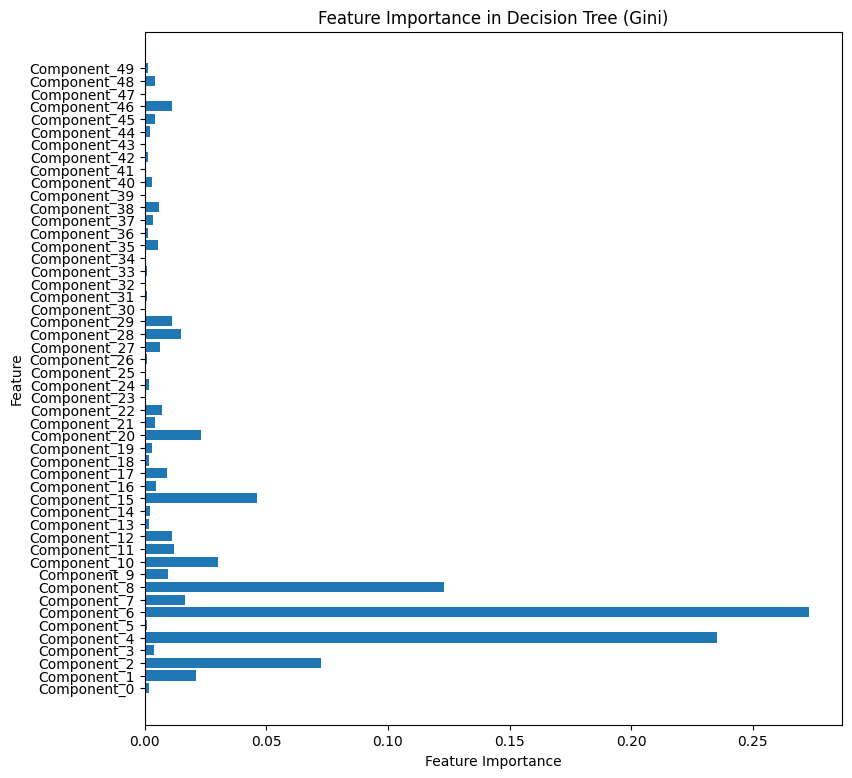

In [36]:
# Feature Importance for Gini Model
num_features = X_svd.shape[1]
generic_feature_names = [f"Component_{i}" for i in range(num_features)]

# Get feature importances for Gini model
feature_importance_gini = best_model_gini.feature_importances_
plt.figure(figsize=(9, 9))
plt.barh(range(num_features), feature_importance_gini, align='center')
plt.yticks(range(num_features), generic_feature_names)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Decision Tree (Gini)')
plt.show()


##Visualization - Decision Tree for Gini

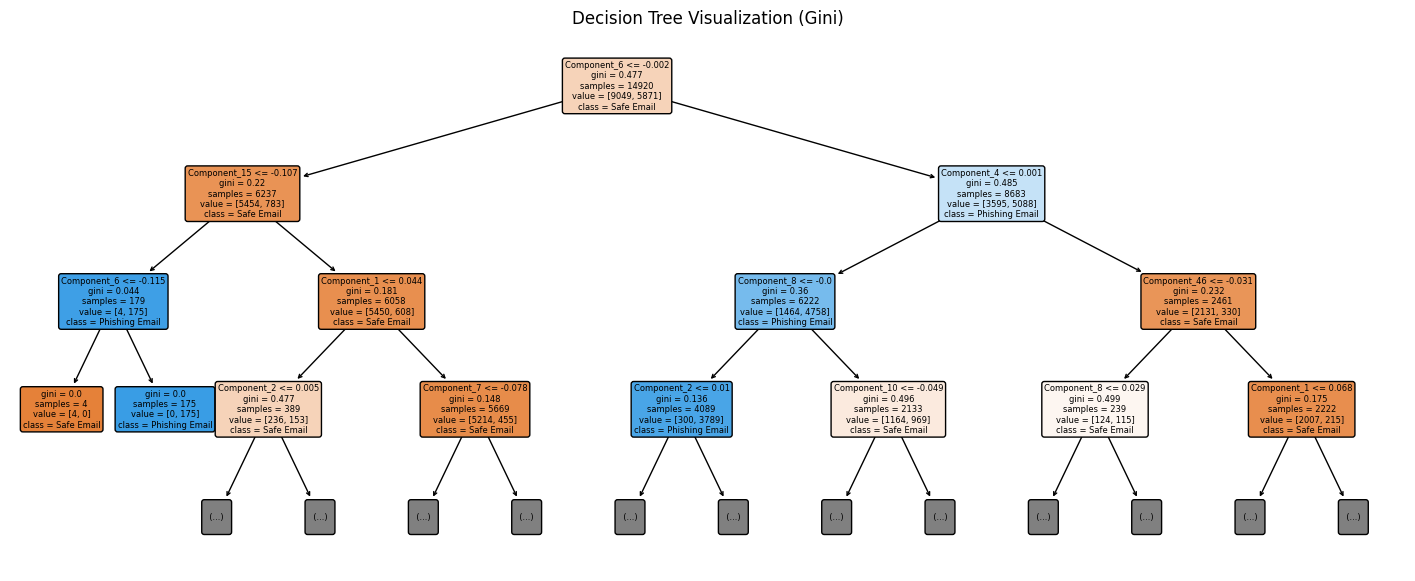

In [38]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Get the best model from GridSearchCV for Gini
best_model_gini = grid_search_gini.best_estimator_

# Generate generic feature names for the SVD components
num_features = X_svd.shape[1]
generic_feature_names = [f"Component_{i}" for i in range(num_features)]

# Plot the decision tree with limited depth for Gini model
plt.figure(figsize=(18,7))
plot_tree(best_model_gini,
          feature_names=generic_feature_names,  # Use generic feature names
          class_names=['Safe Email', 'Phishing Email'],
          filled=True,
          rounded=True,
          max_depth=3,  # Limit the depth of the tree for visualization
          fontsize=6)
plt.title('Decision Tree Visualization (Gini)')
plt.show()


##Model Performance Evaluation and Classification - ENTROPY

In [28]:
# Evaluate the best model for Entropy
best_model_entropy = grid_search_entropy.best_estimator_

# Make predictions on the test set
y_pred_entropy = best_model_entropy.predict(X_test)

# Compute the confusion matrix for Entropy model
conf_matrix_entropy = confusion_matrix(y_test, y_pred_entropy)
print("Confusion Matrix for Entropy:")
print(conf_matrix_entropy)

# Extract TN, FP, FN, TP from the confusion matrix for Entropy model
TN_entropy, FP_entropy, FN_entropy, TP_entropy = conf_matrix_entropy.ravel()
print(f"True Negatives (TN) for Entropy: {TN_entropy}")
print(f"False Positives (FP) for Entropy: {FP_entropy}")
print(f"False Negatives (FN) for Entropy: {FN_entropy}")
print(f"True Positives (TP) for Entropy: {TP_entropy}")

# Compute and print the classification report for Entropy model
class_report_entropy = classification_report(y_test, y_pred_entropy)
print("\nClassification Report for Entropy:")
print(class_report_entropy)

# Compute and print the accuracy score for Entropy model
accuracy_entropy = accuracy_score(y_test, y_pred_entropy)
print("\nAccuracy Score for Entropy:", accuracy_entropy)


Confusion Matrix for Entropy:
[[2107  166]
 [ 114 1343]]
True Negatives (TN) for Entropy: 2107
False Positives (FP) for Entropy: 166
False Negatives (FN) for Entropy: 114
True Positives (TP) for Entropy: 1343

Classification Report for Entropy:
              precision    recall  f1-score   support

          -1       0.95      0.93      0.94      2273
           1       0.89      0.92      0.91      1457

    accuracy                           0.92      3730
   macro avg       0.92      0.92      0.92      3730
weighted avg       0.93      0.92      0.93      3730


Accuracy Score for Entropy: 0.9249329758713136


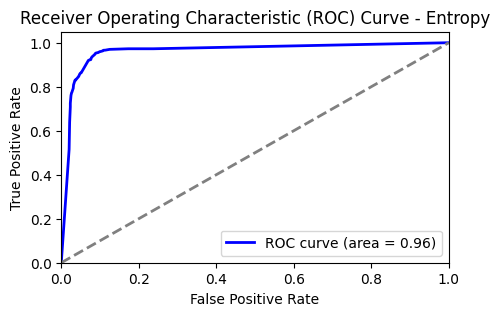

ROC AUC for Entropy: 0.96


In [32]:
# Evaluate the model with ROC curve and AUC for Entropy
y_pred_proba_entropy = best_model_entropy.predict_proba(X_test)[:, 1]  # Get the predicted probabilities for the positive class

# Calculate ROC curve
fpr_entropy, tpr_entropy, thresholds_entropy = roc_curve(y_test, y_pred_proba_entropy)
roc_auc_entropy = roc_auc_score(y_test, y_pred_proba_entropy)

# Plot ROC curve
plt.figure(figsize=(5, 3))
plt.plot(fpr_entropy, tpr_entropy, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_entropy)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Entropy')
plt.legend(loc="lower right")
plt.show()

# Print AUC
print(f"ROC AUC for Entropy: {roc_auc_entropy:.2f}")


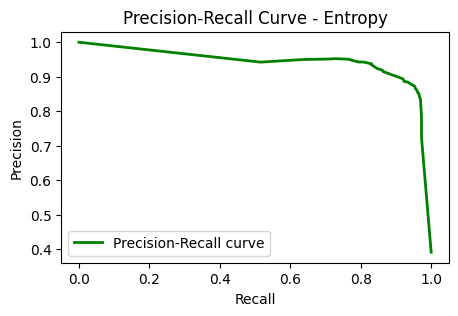

In [33]:
# Calculate Precision-Recall curve for Entropy
precision_entropy, recall_entropy, pr_thresholds_entropy = precision_recall_curve(y_test, y_pred_proba_entropy)

# Plot Precision-Recall curve
plt.figure(figsize=(5, 3))
plt.plot(recall_entropy, precision_entropy, color='green', lw=2, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Entropy')
plt.legend(loc="lower left")
plt.show()


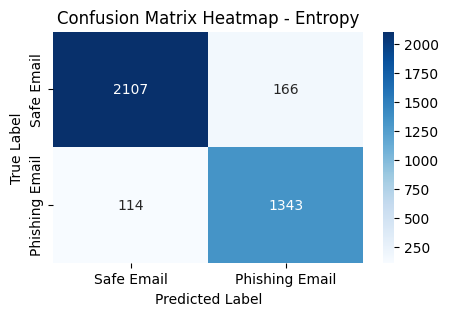

In [34]:
# Visualize the Confusion Matrix as a heatmap for Entropy
plt.figure(figsize=(5, 3))
sns.heatmap(conf_matrix_entropy, annot=True, fmt='d', cmap='Blues', xticklabels=['Safe Email', 'Phishing Email'], yticklabels=['Safe Email', 'Phishing Email'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Heatmap - Entropy')
plt.show()


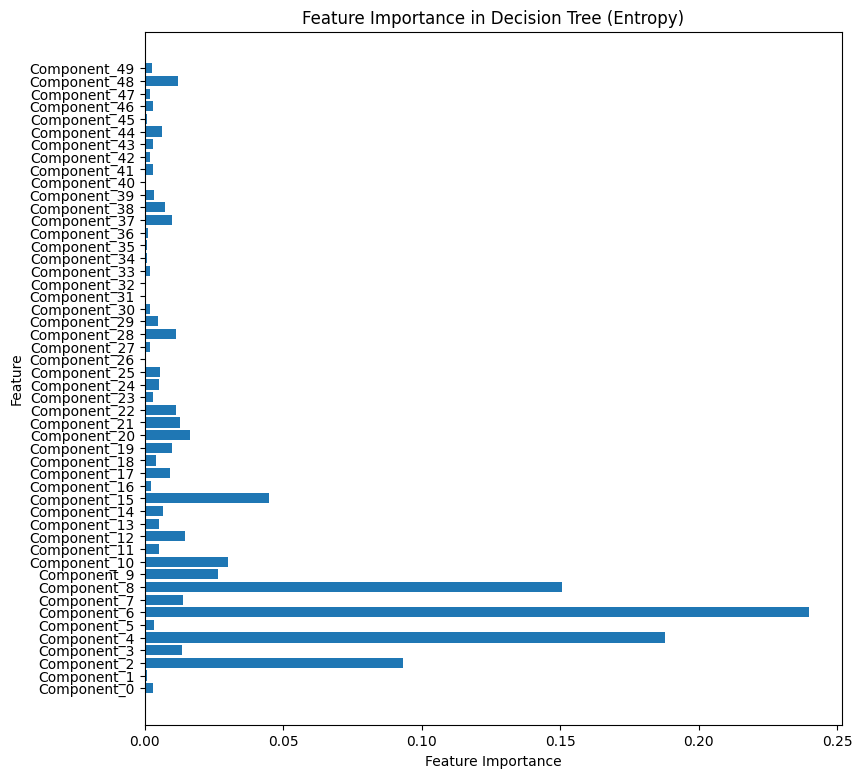

In [37]:
# Feature Importance for Entropy Model
num_features = X_svd.shape[1]
generic_feature_names = [f"Component_{i}" for i in range(num_features)]

# Get feature importances for Entropy model
feature_importance_entropy = best_model_entropy.feature_importances_
plt.figure(figsize=(9, 9))
plt.barh(range(num_features), feature_importance_entropy, align='center')
plt.yticks(range(num_features), generic_feature_names)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Decision Tree (Entropy)')
plt.show()


## Visualization - Decision Tree for Entropy

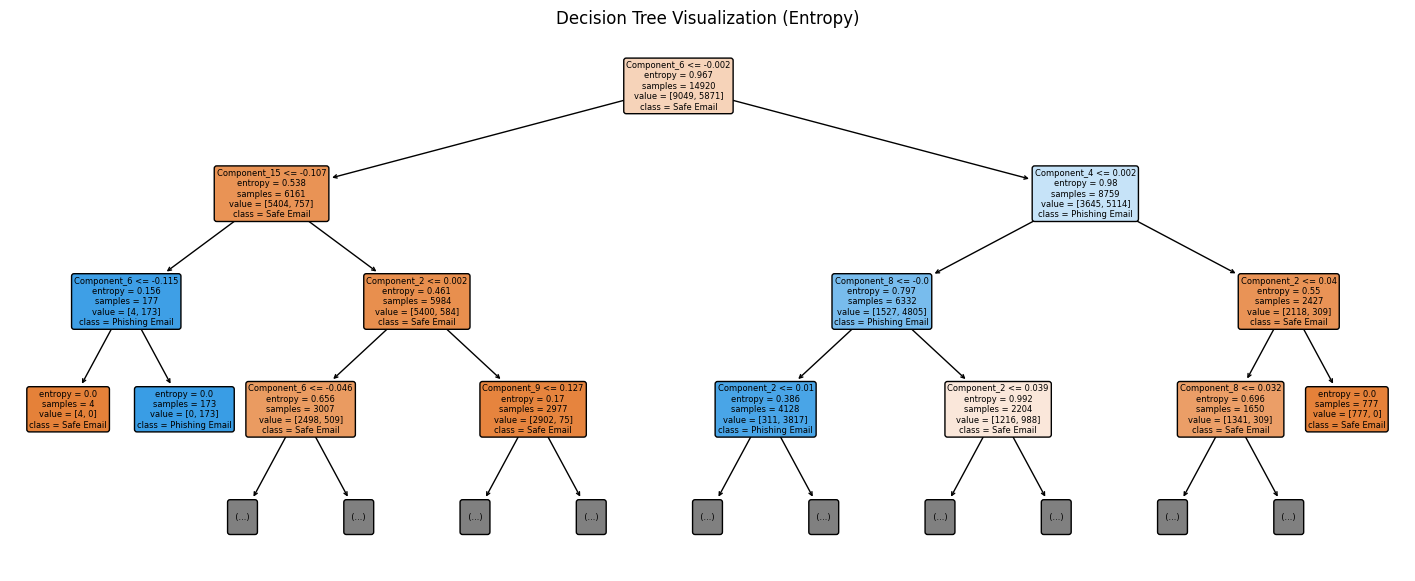

In [39]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Get the best model from GridSearchCV for Entropy
best_model_entropy = grid_search_entropy.best_estimator_

# Generate generic feature names for the SVD components
num_features = X_svd.shape[1]
generic_feature_names = [f"Component_{i}" for i in range(num_features)]

# Plot the decision tree with limited depth for Entropy model
plt.figure(figsize=(18,7))
plot_tree(best_model_entropy,
          feature_names=generic_feature_names,  # Use generic feature names
          class_names=['Safe Email', 'Phishing Email'],
          filled=True,
          rounded=True,
          max_depth=3,  # Limit the depth of the tree for visualization
          fontsize=6)
plt.title('Decision Tree Visualization (Entropy)')
plt.show()
